# forwards-backwards exponential weighted moving average

In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import seaborn as sns
sns.set_theme()
%matplotlib inline
mpl.rcParams['figure.dpi'] = 300

In [2]:
fpath = Path("/home/mst/projects/flyps/myalyce/data/Unfiltered PPG, plus accelerometer/PPG_JoshuaBrewster2023-06-14T15_48_32.828(UTC-07_00).csv")

In [3]:
# fpath = Path("/home/mst/projects/flyps/myalyce/data/ECG Unfiltered 1 (Best quality)/JoshuaBrewster_ECG_2023-05-16T03_09_02.553Z.csv")

In [4]:
orig_df = pd.read_csv(fpath)

In [5]:
# orig_df = orig_df.iloc[2000:2600,:]

In [6]:
orig_df.describe()

,timestamp,red,ir
count,2.560000e+03,2560.000000,2560.000000
mean,1.686783e+12,26497.835547,44339.538672
std,1.481494e+04,110.615264,235.853963
min,1.686783e+12,25943.000000,42951.000000
25%,1.686783e+12,26448.000000,44257.000000
50%,1.686783e+12,26528.000000,44335.000000
75%,1.686783e+12,26580.000000,44468.000000
max,1.686783e+12,26818.000000,44788.000000


In [7]:
df = pd.DataFrame()
df['timestamp'] = orig_df['timestamp']
df['orig'] = orig_df['red'] - orig_df['red'].min()

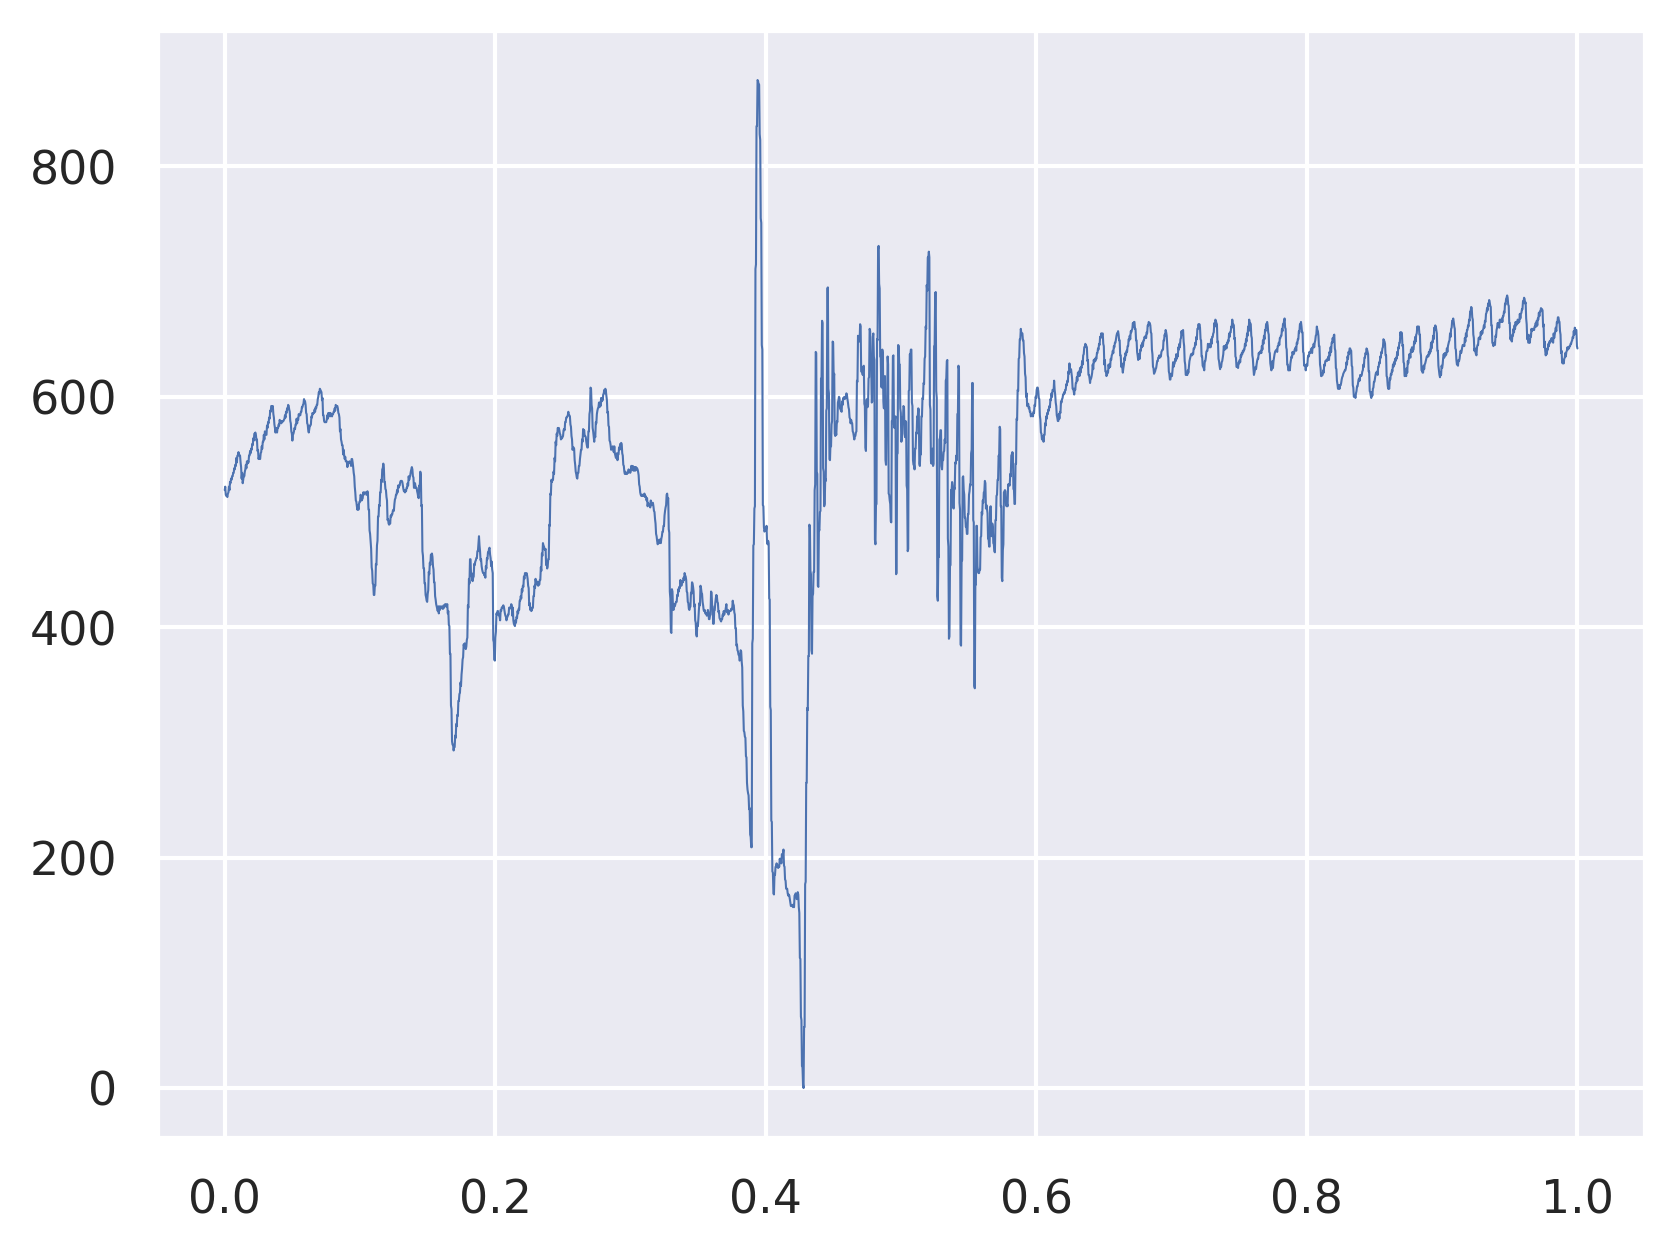

In [8]:
plt.plot(np.linspace(0, 1., num=len(df['orig'])), df['orig'], lw=0.5)

In [9]:
# clip data above this value:
HIGH_CLIP = df['orig'].mean() + 2*df['orig'].std()
HIGH_CLIP

776.0660739197494

In [10]:
# clip data below this value:
LOW_CLIP = df['orig'].mean() - 2*df['orig'].std()
LOW_CLIP

333.60501983025046

In [11]:
# Distance away from the FBEWMA that data should be removed.
DELTA = df['orig'].std()/2
DELTA

55.30763176118738

In [12]:
# How many samples to run the FBEWMA over.
SPAN = 10

In [13]:
# spike amplitude
SPIKE = df['orig'].max() - df['orig'].mean()
SPIKE

320.164453125

In [14]:
def clip_data(unclipped, high_clip, low_clip):
    ''' Clip unclipped between high_clip and low_clip. 
    unclipped contains a single column of unclipped data.'''
    
    # convert to np.array to access the np.where method
    np_unclipped = np.array(unclipped)
    # clip data above HIGH_CLIP or below LOW_CLIP
    cond_high_clip = (np_unclipped > HIGH_CLIP) | (np_unclipped < LOW_CLIP)
    np_clipped = np.where(cond_high_clip, np.nan, np_unclipped)
    return np_clipped.tolist()

In [15]:
df['clipped'] = clip_data(df['orig'], HIGH_CLIP, LOW_CLIP)

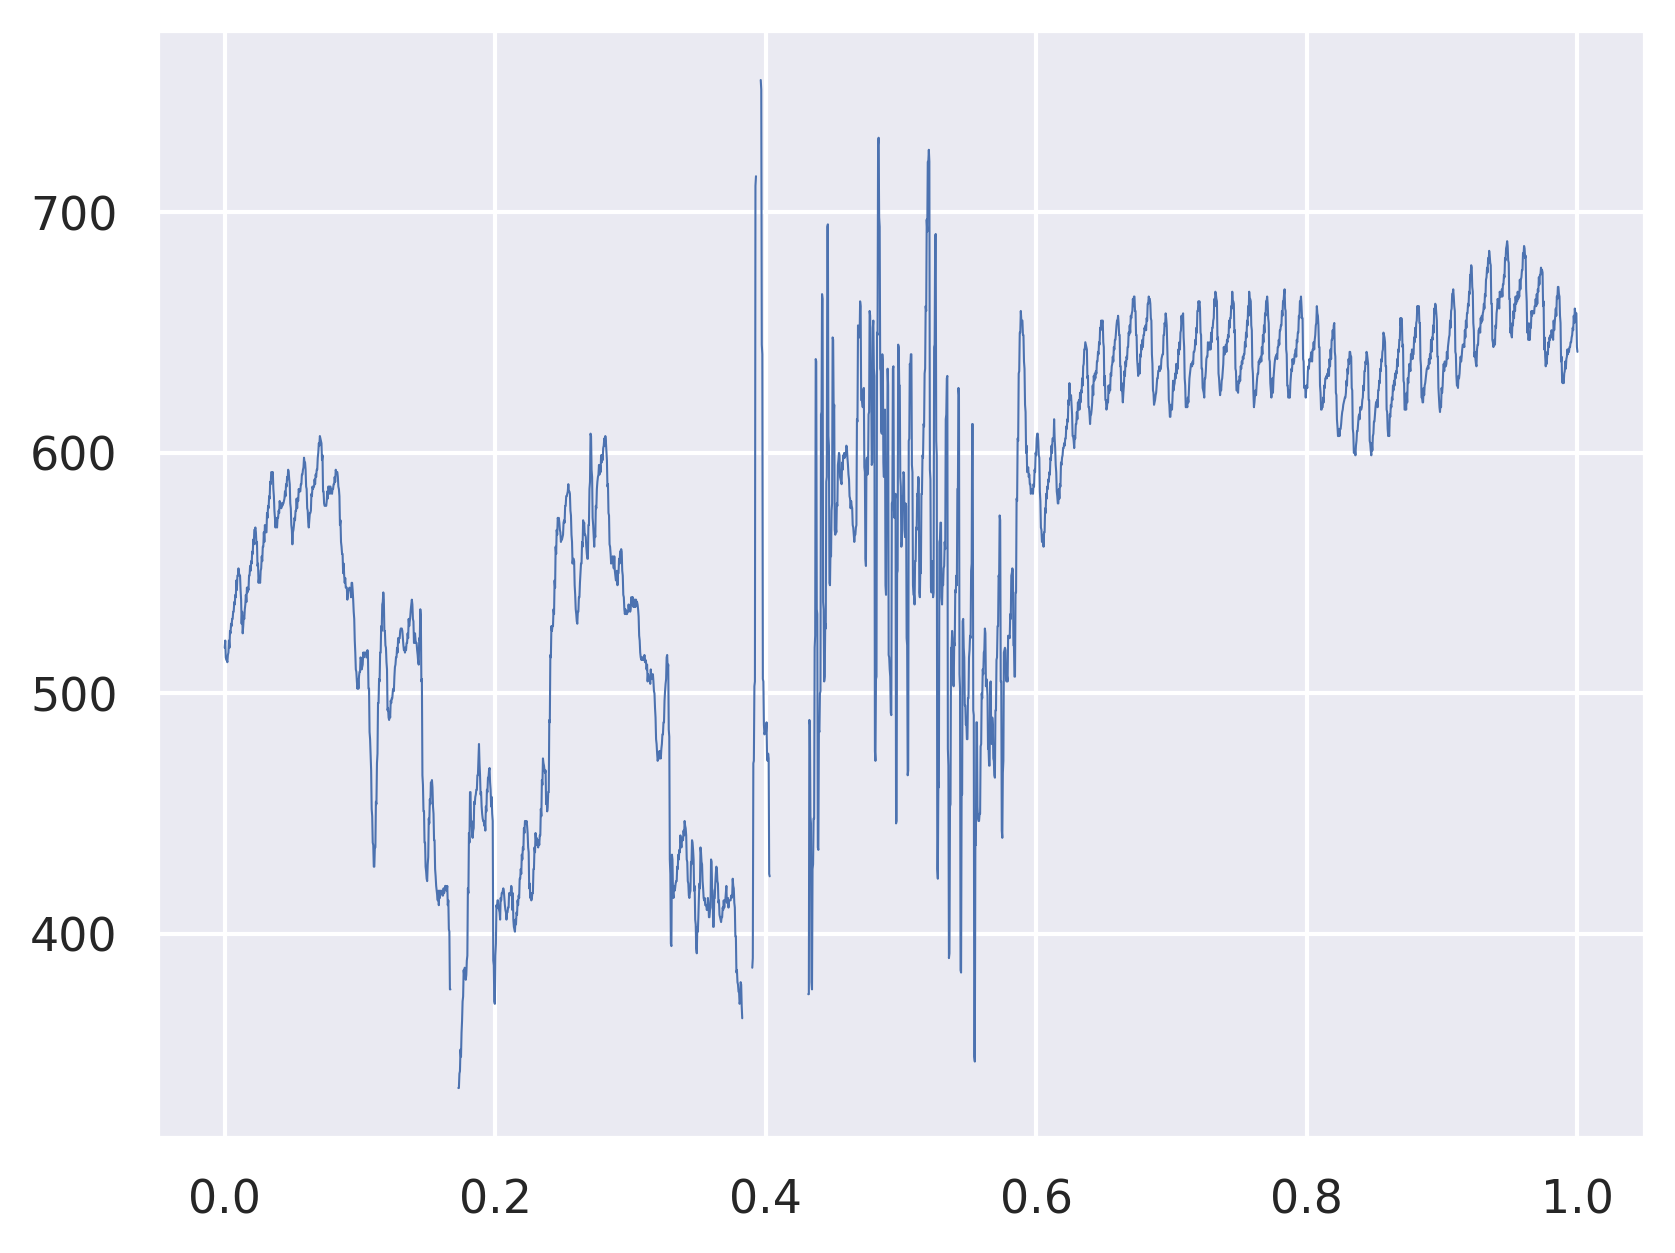

In [16]:
plt.plot(np.linspace(0, 1., num=len(df['clipped'])), df['clipped'], lw=0.5)

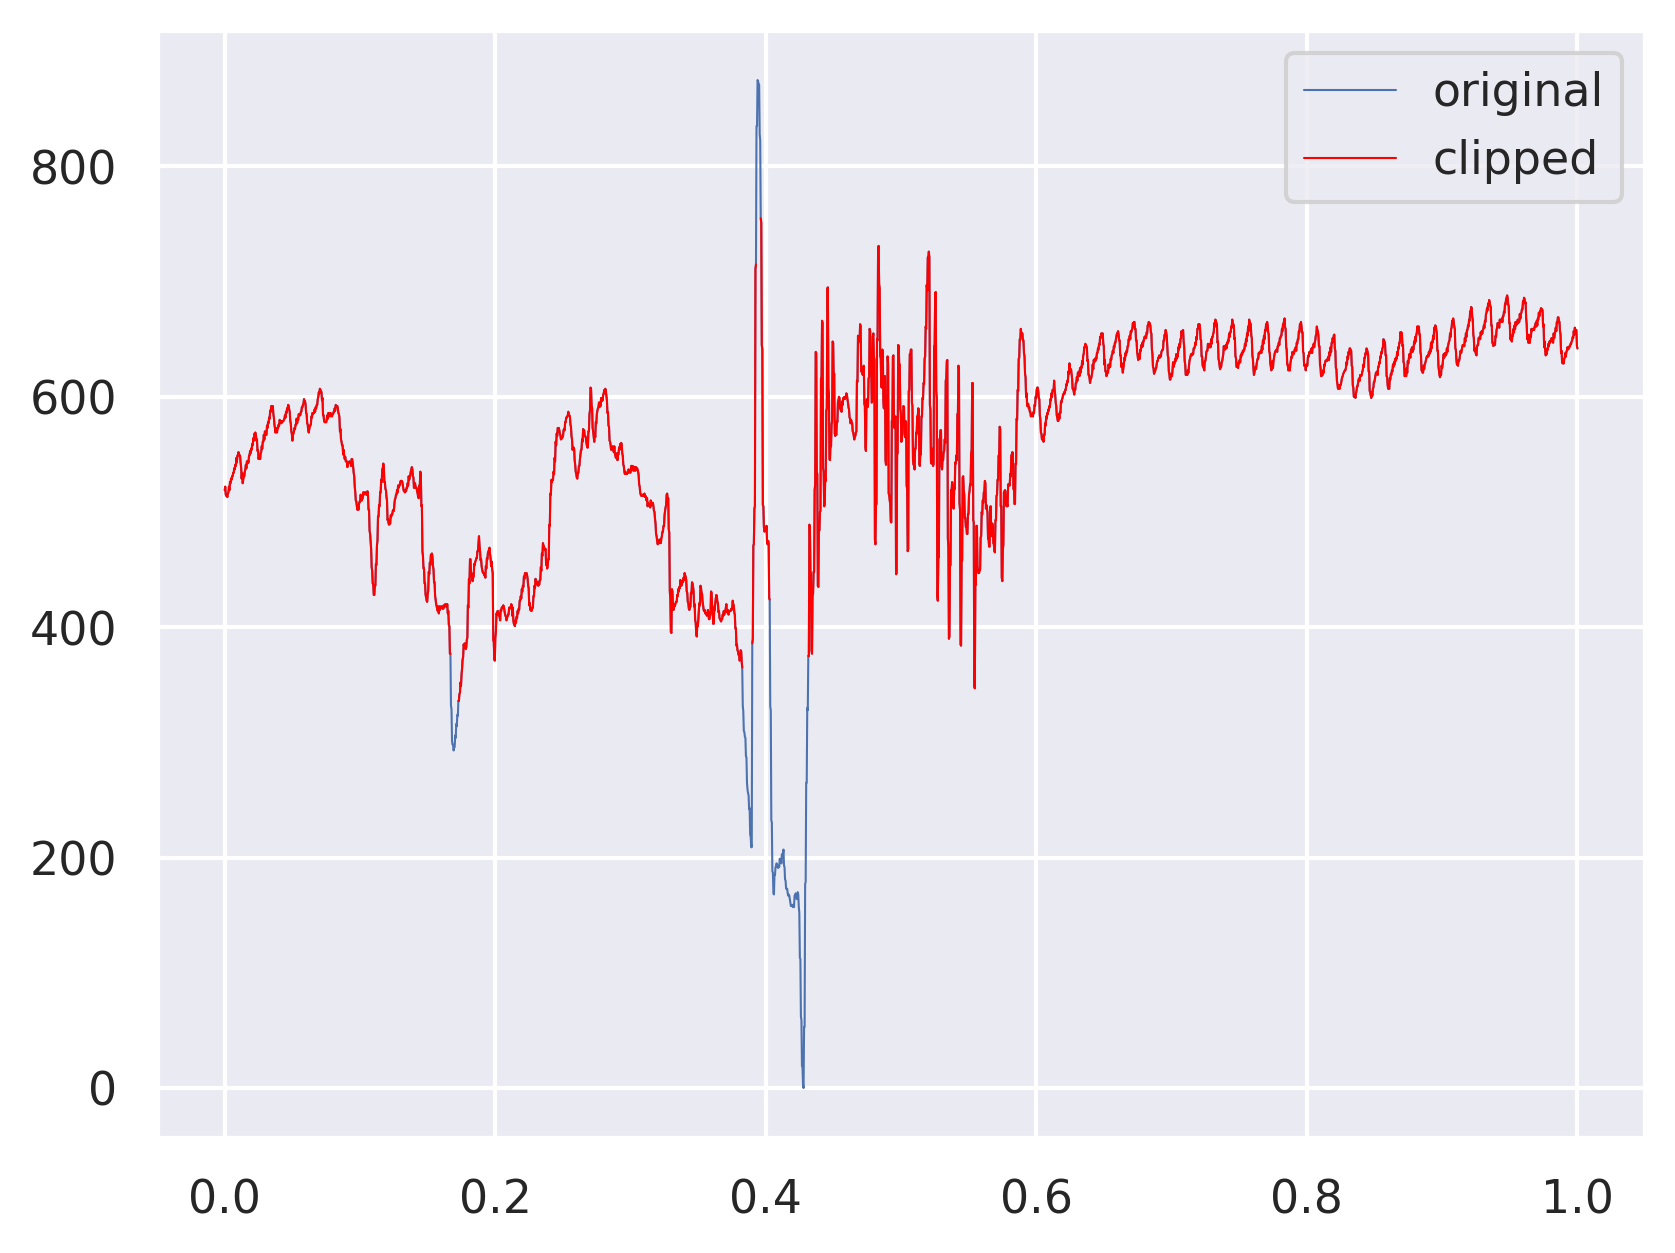

In [17]:
plt.figure()
plt.plot(np.linspace(0, 1., num=len(df['orig'])), df['orig'], lw=0.5)
plt.plot(np.linspace(0, 1., num=len(df['clipped'])), df['clipped'], lw=0.5, color='red')
plt.legend(['original', 'clipped'])

In [18]:
def ewma_fb(df_column, span):
    ''' Apply forwards, backwards exponential weighted moving average (EWMA) to df_column. '''
    # Forwards EWMA.
    fwd = pd.Series.ewm(df_column, span=span).mean()
    # Backwards EWMA.
    bwd = pd.Series.ewm(df_column[::-1],span=10).mean()
    # Add and take the mean of the forwards and backwards EWMA.
    stacked_ewma = np.vstack(( fwd, bwd[::-1] ))
    fb_ewma = np.mean(stacked_ewma, axis=0)
    return fb_ewma

In [19]:
df['ewma'] = ewma_fb(df['clipped'], SPAN)

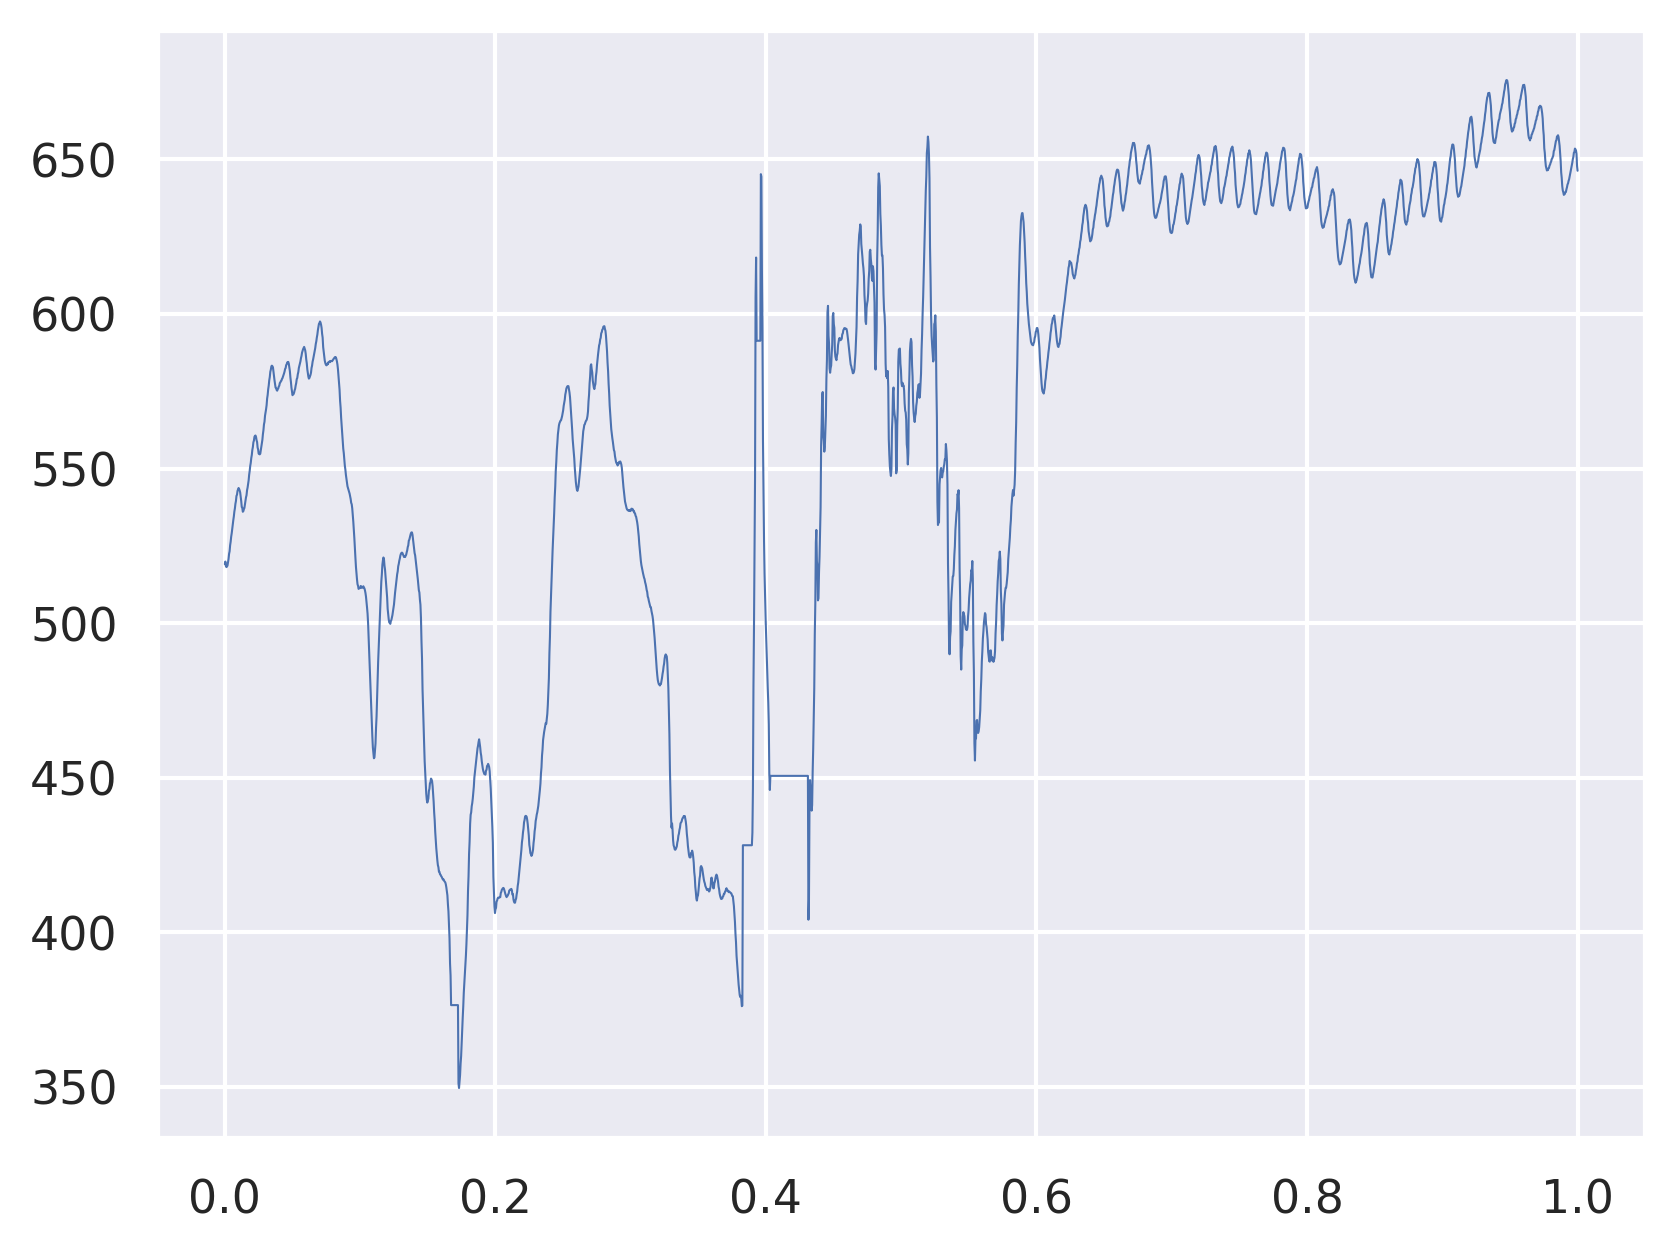

In [20]:
plt.plot(np.linspace(0, 1., num=len(df['ewma'])), df['ewma'], lw=0.5)

In [21]:
def remove_outliers(spikey, fbewma, delta):
    ''' Remove data from df_spikey that is > delta from fbewma. '''
    np_spikey = np.array(spikey)
    np_fbewma = np.array(fbewma)
    cond_delta = (np.abs(np_spikey-np_fbewma) > delta)
    np_remove_outliers = np.where(cond_delta, np.nan, np_spikey)
    return np_remove_outliers

In [22]:
df['wo_outliers'] = remove_outliers(df['clipped'].tolist(), df['ewma'].tolist(), DELTA)

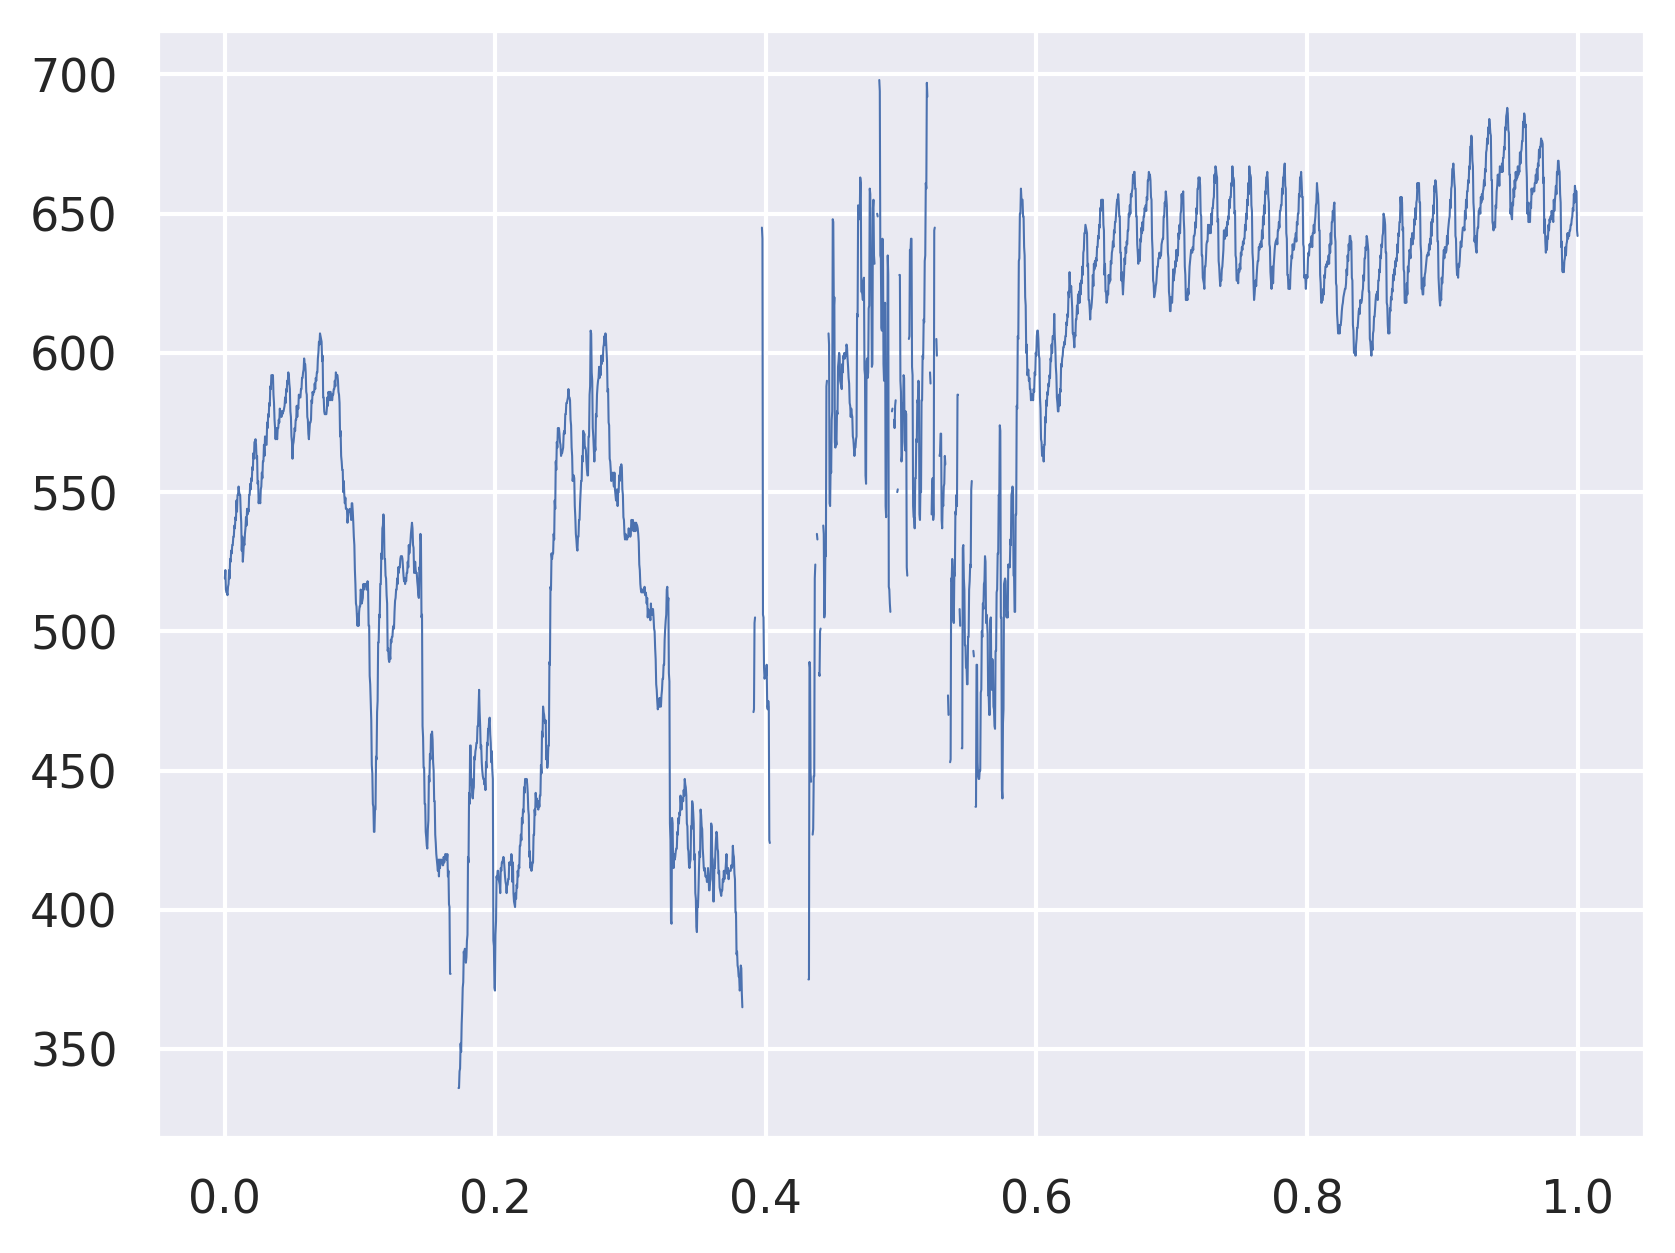

In [23]:
plt.plot(np.linspace(0, 1., num=len(df['wo_outliers'])), df['wo_outliers'], lw=0.5)

In [24]:
df['interpolated'] = df['wo_outliers'].interpolate()

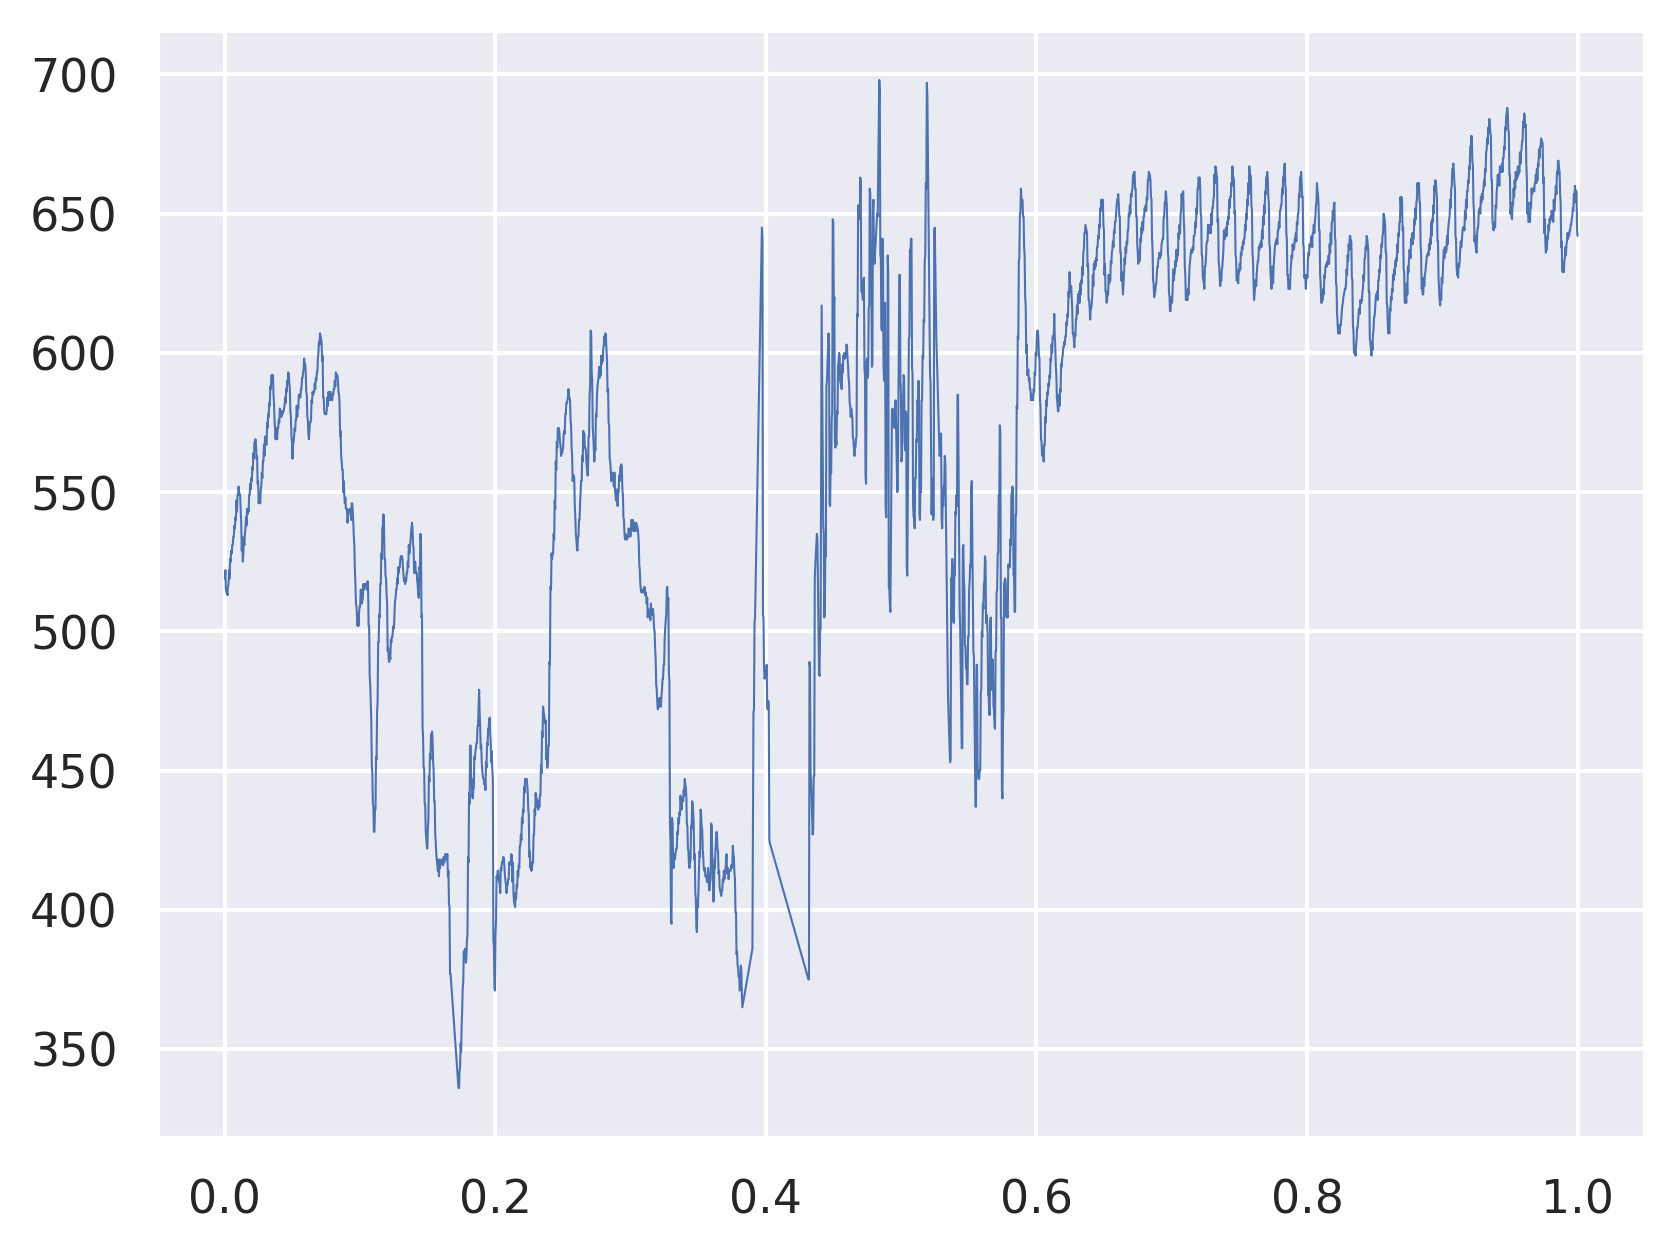

In [25]:
plt.plot(np.linspace(0, 1., num=len(df['interpolated'])), df['interpolated'], lw=0.5)

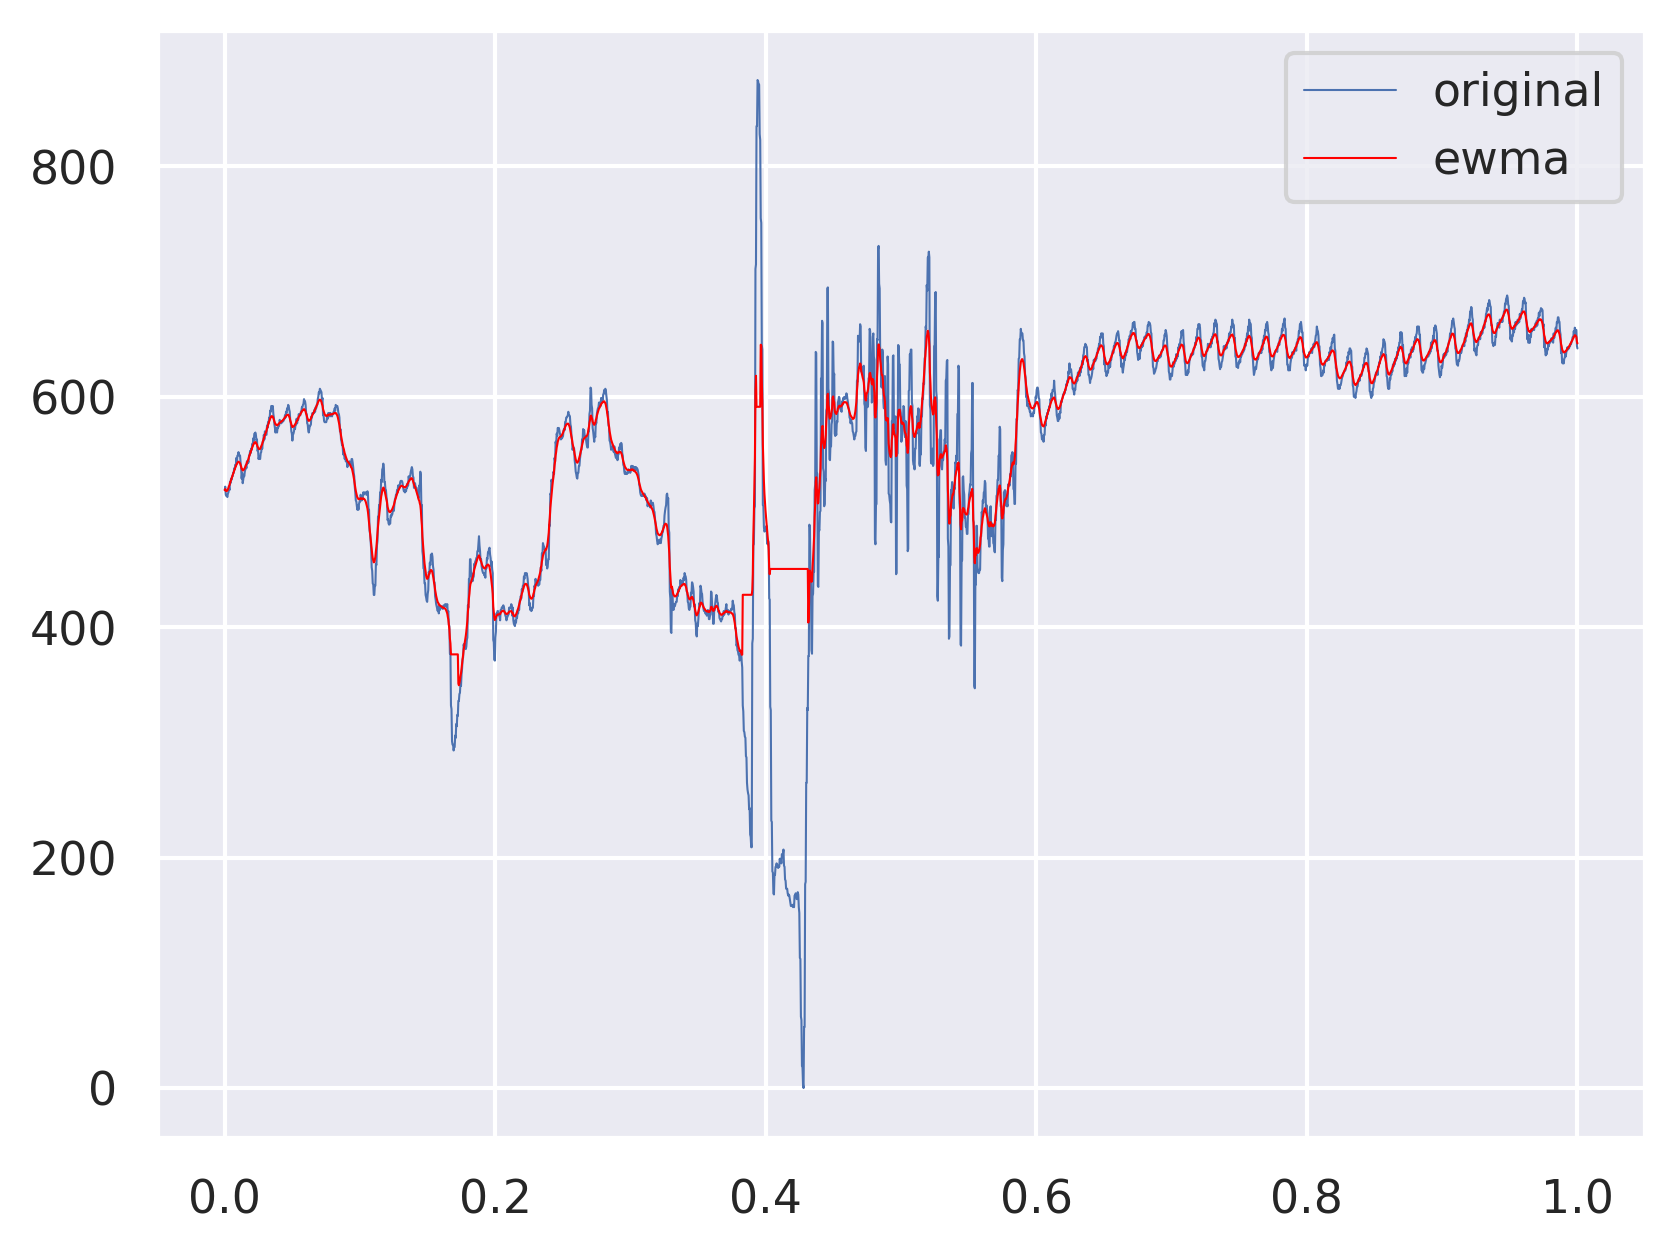

In [26]:
plt.figure()
plt.plot(np.linspace(0, 1., num=len(df['orig'])), df['orig'], lw=0.5)
plt.plot(np.linspace(0, 1., num=len(df['ewma'])), df['ewma'], lw=0.5, color='red')
plt.legend(['original', 'ewma'])

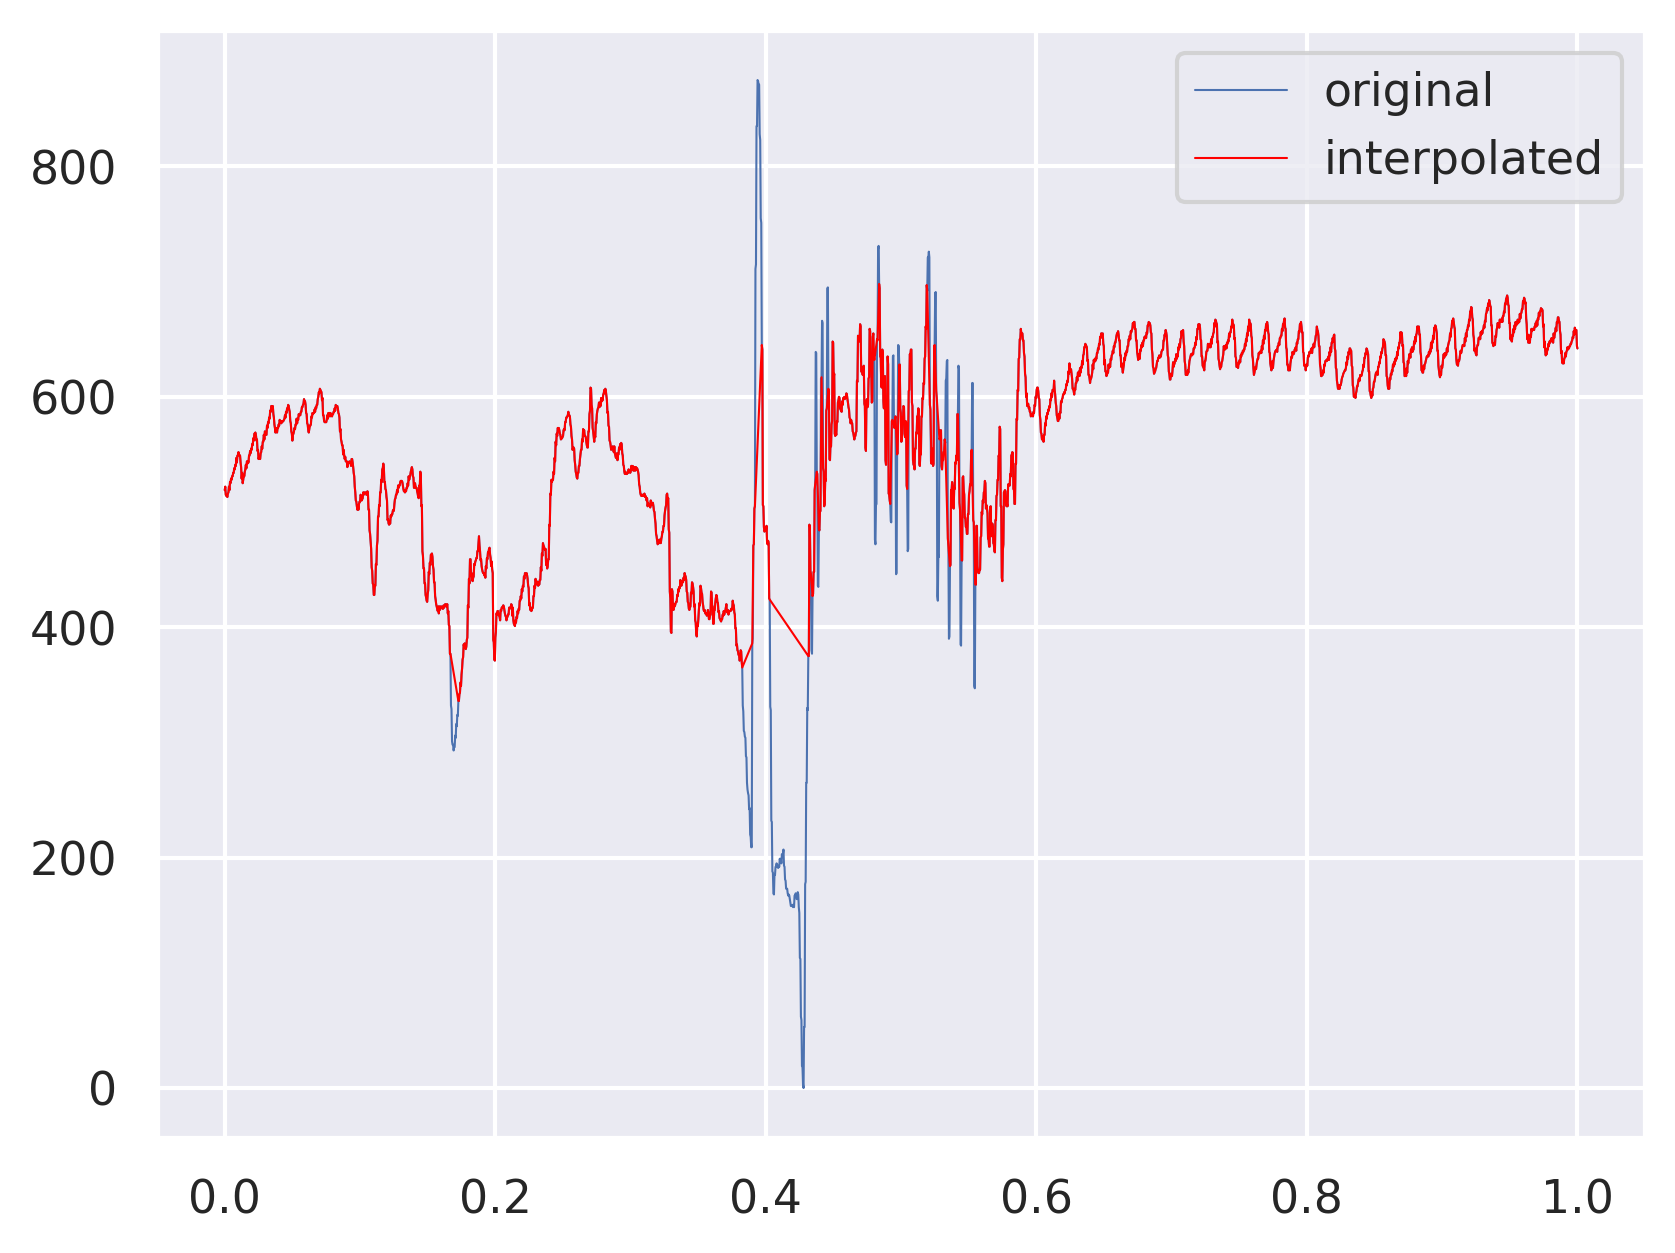

In [27]:
plt.figure()
plt.plot(np.linspace(0, 1., num=len(df['orig'])), df['orig'], lw=0.5)
plt.plot(np.linspace(0, 1., num=len(df['interpolated'])), df['interpolated'], lw=0.5, color='red')
plt.legend(['original', 'interpolated'])
plt.savefig('cut_ewma.png')